In [1]:
from collections import deque
from random import random
from pettingzoo.classic import tictactoe_v3
from torch import nn
from torch.optim import Adam
from copy import deepcopy
import torch
import math
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics import MeanMetric
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Neural Network

In [3]:
class AlphaZeroModel(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(AlphaZeroModel, self).__init__()
        self.v = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Tanh(),
        )

        self.p = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, s):
        p = self.p(s)
        v = self.v(s)
        return p, v

In [4]:
def plot(iteration, losses, win_rates, lose_rates):
    clear_output(True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title(f"Loss. Iteration: {iteration}")
    ax1.plot(losses)

    ax2.set_title(f'Win rate and lose rate')
    ax2.plot(win_rates, label='Win Rate')
    ax2.plot(lose_rates, label='Lose Rate')
    ax2.legend()

    plt.show()

# MCTS

In [5]:
class MCTS:
    def __init__(self, model):
        self.model = model
        self.q_sa = {}  # stores Q values for s,a (as defined in the paper)
        self.n_sa = {}  # stores #times edge s,a was visited
        self.p_s = {}  # stores initial policy (returned by neural net)
        self.action_mask_s = {}

    def simulate(self, env):
        s = env.observe('player_1')['observation']  # (3, 3, 2)
        s = tuple(s.flatten())  # (18,)

        # If terminal state, return -v
        if env.terminations[env.agent_selection] or env.truncations[env.agent_selection]:
            return -env.rewards[env.agent_selection]

        """ EVALUATE """
        # If s is leaf, then evaluate s with model
        if s not in self.p_s:
            return -self.evaluate(env, self.model, s)

        """ SELECT """
        a = self.select(s)

        """ EXPAND WITH RECURSION """
        next_env = deepcopy(env)
        next_env.step(a)
        v = self.simulate(next_env)

        """ BACKTRACK """
        if (s, a) in self.q_sa:
            # Recompute the average
            sum_ = self.n_sa[(s, a)] * self.q_sa[(s, a)]
            sum_ += v
            self.n_sa[(s, a)] += 1
            self.q_sa[(s, a)] = sum_ / self.n_sa[(s, a)]
        else:
            self.q_sa[(s, a)] = v
            self.n_sa[(s, a)] = 1
        return -v

    def evaluate(self, env, model, s):
        observation = env.observe(env.agent_selection)
        action_mask = observation['action_mask']  # (9,)
        observation = observation['observation']  # (3, 3, 2)
        observation = torch.from_numpy(observation).float().view(1, -1)  # (1, 18)

        # Get predictions
        model.eval()
        with torch.no_grad():
            p, v = model(observation)  # (1, 9), (1, 1)
        p = torch.exp(p).cpu().numpy()[0]  # (9,)
        v = v.cpu().numpy()[0][0]  # scalar

        # Legal action masking.
        p *= action_mask

        # Normalizing probabilities
        p_sum = p.sum()
        if p_sum > 0:
            p /= p_sum  # re-normalize
        else:
            print("All valid moves were masked, doing a workaround.")
            p += action_mask
            p /= p.sum()

        self.p_s[s] = p
        self.action_mask_s[s] = action_mask
        return v

    def select(self, s, cpuct=1):
        # pick the action with the highest upper confidence bound
        cur_best = -float("inf")
        best_act = -1
        action_mask = self.action_mask_s[s]
        n_sum = sum(self.n_sa.get((s, a), 0) for a in range(len(action_mask)))
        for a in range(len(action_mask)):
            if action_mask[a]:
                q = self.q_sa.get((s, a), 0)
                p = self.p_s[s][a] + random() * 0.3
                n = self.n_sa.get((s, a), 0)

                u = q + cpuct * p * math.sqrt(n_sum + 1e-6) / (1 + n)
                if u > cur_best:
                    cur_best = u
                    best_act = a
        return best_act

    def get_action_prob(self, env):
        s = env.observe('player_1')['observation']  # (3, 3, 2)
        s = tuple(s.flatten())  # (18,)

        p = np.array([
            self.n_sa.get((s, a), 0)
            for a in range(len(self.p_s[s]))
        ], dtype=np.float32)
        p /= p.sum()
        return p

In [6]:
def evaluate(env, model_1, model_2, n_episodes):
    wins_1, wins_2 = 0, 0
    for _ in tqdm(range(n_episodes), desc='Evaluating'):
        env.reset()
        mcts_ = MCTS(model_1), MCTS(model_2)
        step = 0
        while True:
            step += 1
            mcts = mcts_[int(step % 2 == 0)]

            [mcts.simulate(env) for _ in range(100)]
            p = mcts.get_action_prob(env)
            action = np.random.choice(len(p), p=p)

            env.step(action)

            if env.terminations[env.agent_selection] or env.truncations[env.agent_selection]:
                r = env.rewards['player_1']
                if r > 1:
                    wins_1 += 1
                elif r < 0:
                    wins_2 += 1
                break
    return wins_1, wins_2


def self_play(env, mcts: MCTS):
    tuples = []
    env.reset()

    while True:
        [mcts.simulate(env) for _ in range(250)]

        p = mcts.get_action_prob(env)
        agent = env.agent_selection
        tuples.append([env.observe(agent)['observation'], p, agent])

        action = np.random.choice(len(p), p=p)
        env.step(action)
        if env.terminations[agent] or env.truncations[agent]:
            for tup in tuples:
                tup[2] = env.rewards[tup[2]]
            return tuples

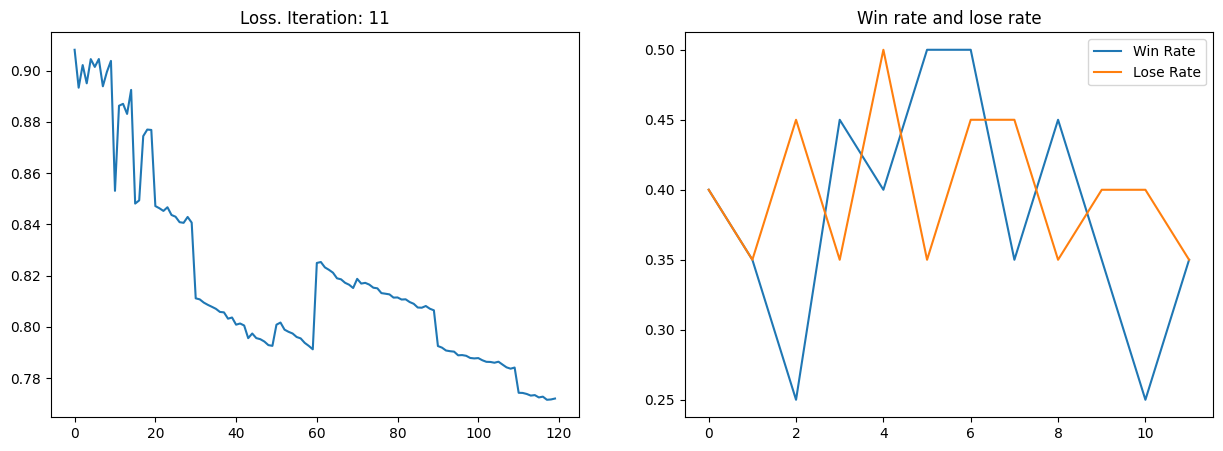

Evaluating:  30%|███       | 3/10 [00:01<00:03,  1.93it/s]

In [ ]:
# def main():
env = tictactoe_v3.env()
n_actions = env.action_space('player_2').n
n_inputs = env.observation_space('player_2')['observation'].sample().flatten().shape[0]

device = 'cpu'
model = AlphaZeroModel(n_inputs, n_actions).to(device)
old_model = deepcopy(model)
optimizer = Adam(model.parameters(), lr=1e-4)

train_examples_history = deque([], maxlen=10)
losses = []
win_rates = []
lose_rates = []

for iteration in range(1000):
    """ Self Play """
    iteration_train_examples = deque([], maxlen=1000)
    for _ in tqdm(range(25), desc='Self-Play'):
        mcts = MCTS(model)
        iteration_train_examples += self_play(env, mcts)

    """ Prepare Training Data """
    train_examples_history.append(iteration_train_examples)
    dataset = [x for xs in train_examples_history for x in xs]
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    """ Train """
    model.train()
    for epoch in tqdm(range(10), desc='Training'):
        loss_mean = MeanMetric()
        for state, p, v in dataloader:
            p_pred, v_pred = model(state.float().to(device))
            loss = (v.to(device) - v_pred).pow(2).mean() - (p.to(device) * p_pred).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_mean(loss.item())
        losses.append(loss_mean.compute())

    """ Evaluate """
    n_eval_episodes = 20
    wins, loses = [0, 0], [0, 0]
    wins[0], loses[0] = evaluate(env, model, old_model, n_eval_episodes // 2)
    loses[1], wins[1] = evaluate(env, old_model, model, n_eval_episodes // 2)
    win_rates.append(sum(wins) / n_eval_episodes)
    lose_rates.append(sum(loses) / n_eval_episodes)
    if win_rates[-1] > lose_rates[-1]:
        old_model = deepcopy(model)

    plot(iteration, losses, win_rates, lose_rates)